In [63]:
import torch
import os
import cv2
import glob
import gdcm
import pydicom
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from tqdm import tqdm
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut
from multiprocessing import Pool
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Parameters
Reference: https://www.kaggle.com/code/theoviel/get-started-quicker-dicom-png-conversion

In [65]:
RESOL = 256
N_FOLDS = 5 #For k-fold cross-validation

In [66]:
BASE_PATH = '/home/junseonglee/01_codes/input/rsna-2023-abdominal-trauma-detection'
train_df = pd.read_csv(f'{BASE_PATH}/train.csv')
train_meta = pd.read_csv(f'{BASE_PATH}/train_series_meta.csv')
train_df = train_df.sort_values(by=['patient_id'])
train_df
#train_df
#patients_id = train_df['patient_id']

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
493,19,1,0,1,0,1,0,0,1,0,0,1,0,0,0
866,26,1,0,1,0,1,0,0,1,0,0,1,0,0,0
1268,33,0,1,0,1,1,0,0,0,1,0,1,0,0,1
1788,43,0,1,0,1,1,0,0,1,0,0,1,0,0,1
3129,96,1,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,65450,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2972,65456,0,1,1,0,1,0,0,1,0,0,0,0,1,1
2973,65495,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2975,65504,1,0,1,0,1,0,0,0,1,0,0,0,1,1


In [84]:
TRAIN_PATH = BASE_PATH + "/train_images/"
n_chunk = 8
patients = os.listdir(TRAIN_PATH)
n_patients = len(patients)
rng_patients = np.linspace(0, n_patients+1, n_chunk+1, dtype = int)
patients_cts = glob.glob(f'{TRAIN_PATH}/*/*')
n_cts = len(patients_cts)
patients_cts_arr = np.zeros((n_cts, 2), int)
data_paths=[]
for i in range(0, n_cts):
    patient, ct = patients_cts[i].split('/')[-2:]
    patients_cts_arr[i] = patient, ct
    data_paths.append(f'{BASE_PATH}/3d_data/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.png')
TRAIN_IMG_PATH = BASE_PATH + '/processed' 

#Generate tables for training
train_meta_df = pd.DataFrame(patients_cts_arr, columns = ['patient_id', 'series'])

#5-fold splitting
train_df['fold'] = 0
labels = train_df[['bowel_healthy','bowel_injury',
                    'extravasation_healthy','extravasation_injury',
                    'kidney_healthy','kidney_low','kidney_high',
                    'liver_healthy','liver_low','liver_high',
                    'spleen_healthy','spleen_low','spleen_high',
                    'any_injury']].to_numpy()

mskf = MultilabelStratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
counter = 0
for train_index, test_index in mskf.split(np.ones(len(train_df)), labels):
    for i in range(0, len(test_index)):
        train_df['fold'][test_index[i]] = counter
    counter+=1

train_meta_df = train_meta_df.join(train_df.set_index('patient_id'), on='patient_id')
train_meta_df['path']=data_paths
train_meta_df.to_csv(f'{BASE_PATH}/train_meta.csv', index = False)
np.unique(train_df['fold'].to_numpy(), return_counts = True)


(array([0, 1, 2, 3, 4]), array([630, 629, 630, 629, 629]))

In [69]:
for i in range(0, n_cts):
    img_list = sorted(glob.glob(f'{TRAIN_IMG_PATH}/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}*'))
    slices = []
    sampled_ind = np.linspace(0, len(img_list)-1, RESOL, dtype = int)
    for j in range(0, RESOL):
        img = cv2.imread(img_list[sampled_ind[j]], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (RESOL, RESOL))
        slices.append(img[None])            
    img_3d = np.concatenate(slices, axis = 0).reshape(RESOL, RESOL*RESOL)

    cv2.imwrite(f'{BASE_PATH}/3d_data/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.png', img_3d)
    #np.save(f'{BASE_PATH}/3d_data/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.npy', img_3d)
    #break
print(np.shape(img_3d))

(256, 65536)


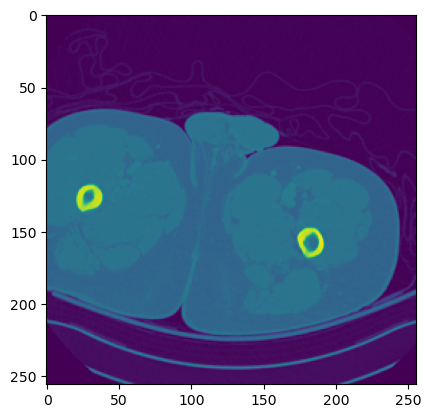

In [48]:
i=0
img = cv2.imread(f'{BASE_PATH}/3d_data/{patients_cts_arr[i,0]}_{patients_cts_arr[i,1]}.png', cv2.IMREAD_GRAYSCALE)
img = img.reshape(256, 256, 256)
plt.imshow(img[0,:,:])
